## Local ADCP Particle test with CMEMS data

parcels environment, at the moment developer: https://docs.oceanparcels.org/en/latest/installation.html
with conda install -c conda-forge leafmap ipyleaflet 
reduced geojson geopandas???

### Use interactive map to determine ship course 

In [1]:
import leafmap 
from ipyleaflet import Rectangle

m = leafmap.leafmap.Map(center=(0, -115), zoom=4)
# Draw a rectange to indicate data availability 
m.add_layer(Rectangle(bounds=((5, -170), (-10, -75))))
m

Map(center=[0, -115], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [2]:
# Save data and read it back to get coordinates
line = m.user_rois
coords =  line.get('features')[0].get('geometry').get('coordinates')
# import geojson
# m.save_draw_features("data.geojson")
# with open('./data.geojson') as f:
#     gj = geojson.load(f)
# features = gj['features']
# coords = features[0].geometry.coordinates
print(coords) 

[[-83.737793, 8.591884], [-86.879883, 4.258768], [-86.879883, -0.747049], [-86.791992, -4.740675], [-86.791992, -9.058702]]


## OLD stuff

In [1]:

import numpy as np
import matplotlib.pyplot as plt 

import pyproj
from shapely.geometry.polygon import Polygon
from shapely.geometry import shape, Point

### Compute ship route as intermediate points beteen CTD stations

In [57]:
# Initialize lists to store intermediate points
sample_lons = []
sample_lats = []

# Loop over station coordinates and calculate intermediate points
i = 0
for i in (range(len(coords)-1)):
    startlong = coords[i][0]
    startlat = coords[i][1]
    endlong = coords[i+1][0]
    endlat = coords[i+1][1]

    # calculate line string along path with segments every TODO hour or 5 min = 3.6*60*5 = 1080 m, for now 5 midpoints
    g = pyproj.Geod(ellps='WGS84')
    # r = g.inv_intermediate(startlong, startlat, endlong, endlat, del_s = 1080)
    r = g.inv_intermediate(startlong, startlat, endlong, endlat, 5, initial_idx=0)
    # store all intermediate points 
    sample_lons.append(r.lons) # stored as a list of arrays
    sample_lats.append(r.lats)

# initial_idx will add begin point to each list (but not end point to avoid dubbling) so add final endpoint manually
sample_lons = np.append(np.hstack(sample_lons), endlong)
sample_lats = np.append(np.hstack(sample_lats), endlat)

### Read sample input data

In [5]:
from datetime import timedelta
import math

from parcels import (
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
)

In [35]:
# Load the CMEMS data (3 days manually downloaded)
example_dataset_folder = "../Data"
filenames = {
    "U": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "V": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "S": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-so_hcst_R20210113.nc",
    "T": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-thetao_hcst_R20210113.nc",
}
variables = {'U': 'uo', 'V': 'vo', 'S':'so', 'T':'thetao'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time', 'depth':'depth'}

# create the fieldset and set interpolation methods
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, time_periodic=timedelta(days=3))
fieldset.T.interp_method = "linear_invdist_land_tracer"
fieldset.S.interp_method = "linear_invdist_land_tracer"

# determin top and bottom layer in the hydrodynamic data
fieldset.mindepth = math.ceil(fieldset.U.depth[0])
fieldset.maxdepth = math.floor(fieldset.U.depth[-1])

ini_lon = coords[0][0]
ini_lat = coords[0][1]
print(ini_lon, ini_lat)

-108.457031 3.337954


In [36]:
# Create and initialize Variable particles to sample the ocean
class SampleParticle(JITParticle):
    """Define a new particle class with Variables"""
    U = Variable('U', dtype=np.float32, initial=0.0)
    V = Variable('V', dtype=np.float32, initial=0.0)

# define function sampling u and v as in https://docs.oceanparcels.org/en/latest/examples/tutorial_sampling.html
def SampleVel_correct(particle, fieldset, time):
    # TODO attention: samples particle velocity in units of the mesh (deg/s or m/s)
    particle.U, particle.V = fieldset.UV[time, particle.depth, particle.lat, particle.lon, particle]

# Attempt for ADCP like particle TODO accurate depths 
depthnum = 5
# Initiate ADCP like particle set 
pset = ParticleSet.from_list(
    fieldset=fieldset, pclass=SampleParticle, lon=np.full(depthnum,ini_lon), lat=np.full(depthnum,ini_lat), depth=np.linspace(5, 1000, num=depthnum)
)

# Casting the function to a kernel
SampleVel_kernel = pset.Kernel(SampleVel_correct)  

# only execute the sampling kernels to record the init values of the particles
pset.execute(SampleVel_kernel, dt=0)

INFO: Compiled ArraySampleParticleSampleVel_correct ==> /tmp/parcels-382783/lib348184e9bb192099d44b70860e7789a1_0.so


### Run simulation

In [58]:
# create a ParticleFile to store the output
# Note: Do not specify the outputdt yet, so we can manually write the output
output_file = pset.ParticleFile(name="LeafmapADCPtest.zarr")

# write the particle data every hour
outputdt = timedelta(hours=1).total_seconds()

# Choose which kernels to use
kernels = SampleVel_kernel

c = 0
for i in range(len(sample_lons)):
    # write the initialised particles 
    output_file.write(pset, time)
 
    if sample_lons[i] == coords[c][0]:
        print('CTD time!')
        c += 1

    # set the particle lon and lat
    pset.lon[:] = sample_lons[i]
    pset.lat[:] = sample_lats[i]
    pset.time[:] += outputdt
    time = pset.time[0]
    print(pset.time[0])

    # execute the kernels i.e. sample at the new location
    # pset.execute(kernels, dt=outputdt)
    # print(f"Writing time {time}")

CTD time!
367200.0
370800.0
374400.0
378000.0
381600.0
CTD time!
385200.0
388800.0
392400.0
396000.0
399600.0
CTD time!
403200.0


In [41]:
198000-194400 
print(pset.lon)

[-117.64258 -117.64258 -117.64258 -117.64258 -117.64258]


### Do some plotting to check output

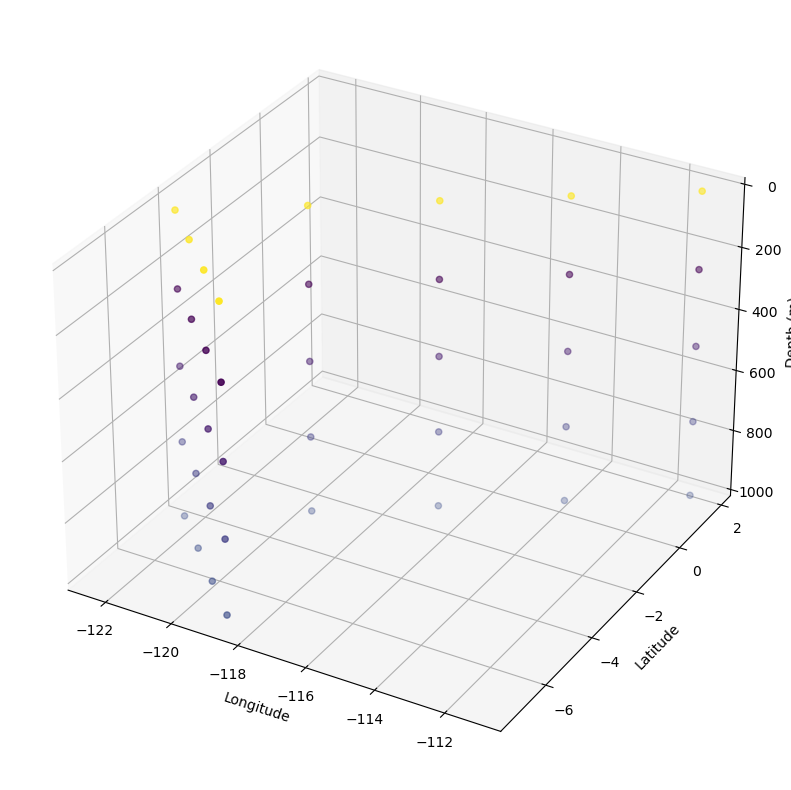

In [42]:
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D

# Open output and read to x, y, z
ds = xr.open_zarr("LeafmapADCPtest.zarr")
# ds = xr.open_zarr('tmp.zarr')
x = ds["lon"][:].squeeze()
y = ds["lat"][:].squeeze()
z = ds["z"][:].squeeze()
U = ds["U"][:].squeeze()
V = ds["V"][:].squeeze()
ds.close()

# Plot Particle depth
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
cb = ax.scatter(x, y, z, c=V, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
plt.show()

In [21]:
print(ds)

<xarray.Dataset>
Dimensions:     (trajectory: 20, obs: 7)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6
  * trajectory  (trajectory) int64 40 41 42 43 44 45 46 ... 53 54 55 56 57 58 59
Data variables:
    U           (trajectory, obs) float32 dask.array<chunksize=(20, 1), meta=np.ndarray>
    V           (trajectory, obs) float32 dask.array<chunksize=(20, 1), meta=np.ndarray>
    lat         (trajectory, obs) float32 dask.array<chunksize=(20, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(20, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(20, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(20, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.2


In [16]:
shapes = []
for feature in features:
  shapes.append(shape(feature['geometry']))
  
lons = []
lats = []
npts_line = 1

for set_shape in shapes:
  # If the release location is a point
  if set_shape.type.lower() == 'point':
    lons.append(set_shape.coords.xy[0][0])
    lats.append(set_shape.coords.xy[1][0])
    
  # If the release location is a linestring (could be multiple lines)
  elif set_shape.type.lower() == 'linestring':
    pointlist_lon = set_shape.coords.xy[0]
    pointlist_lat = set_shape.coords.xy[1]

    for i in range(len(pointlist_lon)-1):
      point1 = [pointlist_lon[i], pointlist_lat[i]]
      point2 = [pointlist_lon[i+1], pointlist_lat[i+1]]
      lons.append(np.linspace(point1[0], point2[0], npts_line, endpoint=True))
      lats.append(np.linspace(point1[1], point2[1], npts_line, endpoint=True))

lons = np.hstack(np.asarray(lons))
lats = np.hstack(np.asarray(lats))

# plt.scatter(lons, lats, s=2)
# plt.show()

### Compute distance travelled by ship

In [6]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

### Create particles and initalize


### Determine ship course and add as kernel 

In [22]:
# Predetermine ship route
# Cruising speed Pelagia (and Anna Weber) is 9 knp https://www.nioz.nl/application/files/3614/9744/8746/Pelagia_Technical_specifications-2016.pdf
# survey speed nog iets lager? Zoals bij https://schmidtocean.org/rv-falkor/ship-specifications/
# 7 knp = 13 km/h = 3.6 m/s

coords 

speed = 3.6
cur_loc = fieldset.ship_loc
target_lat = fieldset.ship_lats[cur_loc]
# target_lon = fieldset.ship_coords[fieldset.ship_loc][1]
target_lat = 50
target_lon = 5
# # slow down when close to target
# if target_lat - particle.lat < 3.6*3600/1.11e5 or target_lon - particle.lon < 3.6*3600/(1.11e5 * math.cos(particle.lat * math.pi / 180)):
#     speed = speed/4

# calculate distance to target
# convert decimal degrees to radians 
lon1, lat1, lon2, lat2 = map(math.radians, [particle.lon, particle.lat, target_lon, target_lat])
# haversine formula 
dlon = lon2 - lon1 
dlat = lat2 - lat1 
a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
c = 2 * math.asin(math.sqrt(a)) 
r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
dist = c * r
print(dist)

# determine ship direction
heading = math.sqrt((target_lat - particle.lat)**2 + (target_lon - particle.lon)**2)

# # OR calculate bearing
# # Convert latitude and longitude to radians
# lat1 = math.radians(particle.lat[0])
# long1 = math.radians(particle.lon[0])
# lat2 = math.radians(target_lat)
# long2 = math.radians(target_lon)

# # Calculate the bearing
# bearing = math.atan2(
#     math.sin(long2 - long1) * math.cos(lat2),
#     math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(long2 - long1)
# )
# # Convert the bearing to degrees
# bearing = math.degrees(bearing)
# # Make sure the bearing is positive
# bearing = (bearing + 360) % 360


# calculate e/w and n/s speed (m/s)
lat_add = (target_lat - particle.lat)/(heading/speed)
lon_add = (target_lon - particle.lon)/(heading/speed)
# convert to lat/lon
lat_add_deg = lat_add / 1.11e5
lon_add_deg = lon_add / (1.11e5 * math.cos(particle.lat * math.pi / 180))
# add to particle position
particle.lat += lat_add_deg * particle.dt
particle.lon += lon_add_deg * particle.dt
# update loc if close to target TODO target reached
# if target_lat - particle.lat < 3.6*3600/1.11e5 or target_lon - particle.lon < 3.6*3600/(1.11e5 * math.cos(particle.lat * math.pi / 180)):
#     loc += 1
#     speed = 3.6



NotImplementedError: Subscript not implemented for object type ConstNode